# Clustering

Most of the other methods we have seen until now, such as regression and classification, focus on supervised learning: we observe both a set of features as well as a response or outcome variable.  
The clustering algoritms focus on unsupervised learning: **no label is provided** in the data samples.  There is no target variable. It is often easier to obtain unlabeled data than labeled data which require human intervention.   
Unsupervised algorithm do not attempt to predict a response; the goal is to discover interesting things about the data set such as can we find subgroups among the observations?  
In this sense, one of the method we have seen - the Principal Components Analysis (PCA) - can be regarded as an unsupervised learning method: it's a tool that pre-process or visualise the data before supervised techniques are applied; it doesn't predict.

Another important and broad class of methods is **clustering**.  
Clustering groups samples that are similar within the same cluster.    
The more similar the samples belonging to a cluster group are (and conversely, the more dissimilar samples in separate groups), the better the clustering algorithm has performed.  
To make this possible, we must define what it means for two or more observations **to be similar**. Since clustering is an unsupervised algorithm, this similarity metric must be measured automatically and based solely on the data. Indeed, this is often a domain-specific consideration and the similarity metric may vary according to the domain.
  
Examples of clustering are grouping movies by ratings or shoppers by their purchase histories or cancer patients by their gene expression measurements.  
The implementation details and definition of similarity are what differentiate the many clustering algorithms.

## K-means algorithm
In K-means clustering we seek to partition the observations into a **pre-specified number K of clusters**, not overlapping (no observation belongs to more than one cluster).  
The K-Means way of doing this, is to iteratively separate your samples into a user-specified number of "K" cluster groups of roughly **equal variance**.  
The idea is that a good clustering is one for which the intra-cluster variation (within the cluster) is as small as possible.  We want to minimise the sum of all intra-cluster variations, for all K clusters.  
Typically the Euclidean distance is used.  
The algorithm is:  
1. randomly assign a number - from 1 to K - to each of the observations.
1. Iterate until the cluster assignments stop changing:
2. for each of the clusters, compute its *centroid*: the vector of the feature means.
2. assign each observation to the cluster whose centroid is closest (using e.g. the Euclidean distance).  
The algorithm is guaranteed to decrease the value of the objective (the function to minimise) at each step, however is not guaranteed to give the global minimum because the function is not convex, so there is not always one minimum, there could be many and the algorithm could get stuck in one of them.  
  
Let's see a couple of examples of K-Means algorithm applied to concrete problems.

# Grocery customers
For the first example, we will use a dataset called Wholesale Customers that refers to clients of a grocery distributor.  
There are multiple product categories – Fresh, Milk, Grocery, etc. - which are the features.  
The values represent the annual spending in monetary units (m.u.) purchased by each client for each product.  
There are no target variables.  
  
Our aim is to make clusters from this data that can segment similar clients together. 

## Read and process the data

The dataset is available from the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wholesale+customers)

In [1]:
import pandas as pd


In [2]:
#
# Load up the dataset. 
#
wsc = pd.read_csv("../Datasets/Wholesale-customers.csv")

It may or may not have invalid values (NaN) in it.  
We make sure to catch and remove them, by setting them to '0'.  
This is valid for this dataset, since if the value is missing, you can assume no $ was spent on it.

In [3]:
if wsc.isnull().values.any() == True:
  print("substituted all NaN with Zero")
  wsc.fillna(0, inplace=True)
else:
  print("No NaN found!")


No NaN found!


In [4]:
wsc.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


We get rid of the 'Channel' and 'Region' columns, since we'll be investigating as if this were a single location wholesaler, rather than a national / international one.  
Leaving these fields in here would cause KMeans to examine and give weight to them.  
The other features are the product categories.

In [5]:
wsc.drop(['Channel', 'Region'], axis=1, inplace = True)

In [6]:
print('Wholesale customers has {} samples with {} features each'.format(*wsc.shape))

Wholesale customers has 440 samples with 6 features each


In [7]:
wsc.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Before unitizing / standardizing / normalizing the data in preparation for K-Means, it's a good idea to get a quick peek at it. You can do this using the *.describe()* method, or even by using the built-in pandas *.plot.hist()*:

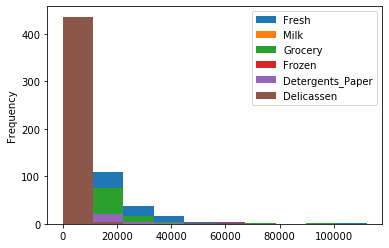

In [8]:
wsc.plot.hist();

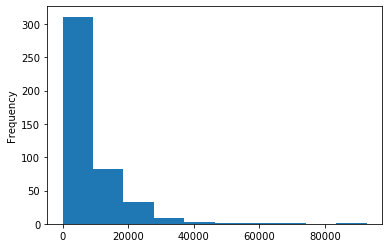

In [9]:
wsc.Grocery.plot.hist();

You may notice there's a pretty big gap between the top customers in each feature category and the rest.  
Some feature scaling algorithms won't get rid of outliers, so it's a good idea to handle that manually - particularly if your goal is NOT to determine the top customers.  
After all, you can do that with a simple *Pandas .sort_values()* and not a machine learning clustering algorithm.  
From a business perspective, you're probably more interested in clustering your +/- 2 standard deviation customers, rather than the creme de la creme, or bottom of the barrel'ers.

In [10]:
#
# Remove top 5 and bottom 5 samples for each column:
drop = {}
for col in wsc.columns:
  # Bottom 5
  sort = wsc.sort_values(by=col, ascending=True)
  if len(sort) > 5: sort=sort[:5]
  for index in sort.index: drop[index] = True # Just store the index once

  # Top 5
  sort = wsc.sort_values(by=col, ascending=False)
  if len(sort) > 5: sort=sort[:5]
  for index in sort.index: drop[index] = True # Just store the index once

Drop rows by index. We do this all at once in case there is a collision. This way, we don't end up dropping more rows than we have to, if there is a single row that satisfies the drop for multiple columns.  
Since there are 6 rows, if we end up dropping < 5 * 6 * 2 = 60 rows, that means there indeed were collisions.

In [11]:
print (f"Dropping {len(drop)} Outliers...")
wsc.drop(inplace=True, labels=drop.keys(), axis=0)

wsc.describe()

Dropping 42 Outliers...


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,10996.231156,5144.090452,7091.711055,2639.721106,2562.974874,1278.736181
std,9933.042596,5057.406574,6923.019293,2974.246906,3608.176776,1220.745297
min,37.000000,258.000000,314.000000,47.000000,10.000000,11.000000
25%,3324.500000,1571.250000,2155.500000,749.750000,273.250000,409.500000
50%,8257.500000,3607.500000,4573.000000,1526.000000,812.000000,946.500000
75%,15828.500000,6953.250000,9922.250000,3370.250000,3841.500000,1752.250000
max,53205.000000,29892.000000,39694.000000,17866.000000,19410.000000,7844.000000


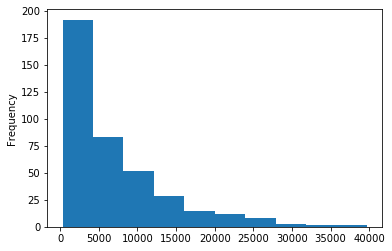

In [12]:
wsc.Grocery.plot.hist();

## Data normalisation 
What are you interested in?
  
Depending on what you're interested in, you might take a different approach to normalizing/standardizing the data.
   
You should note that all columns left in the dataset are of the same unit.  
You might ask yourself, do I even need to normalize / standardize the data?  
The answer depends on what you're trying to accomplish. For instance, although all the units are the same (generic money unit), the price per item in your store isn't. There may be some cheap items and some expensive one. If your goal is to find out what items people buy tend to buy together but you didn't unitize properly before running kMeans, the contribution of the lesser priced item would be dwarfed by the more expensive item.
  
Suffice to say, at the end of the day, you're going to have to know what question you want answered and what data you have available in order to select the best method for your purpose. Luckily, SKLearn's interfaces are easy to switch out so in the mean time, you can experiment with all of them and see how they alter your results.
  
  
5-sec summary:
  
- NORMALIZATION: Let's say your user spend a LOT. Normalization divides each item by the average overall amount of spending. Stated differently, your new feature is = the contribution of overall spending going into that particular item: money spent on feature / money overall spent by sample.
 
- MINMAX: What % in the overall range of money spent by all users on THIS particular feature is the current sample's feature at? When you're dealing with all the same units, this will produce a near face-value amount. Be careful though: if you have even a single outlier, it can cause all your data to get squashed up in lower percentages.  
Imagine your buyers usually spend 100 dollars on wholesale milk, but today only spent 20 dollars. This is the relationship you're trying to capture with MinMax.   
NOTE: MinMax doesn't standardize (std. dev.); it only normalizes / unitizes your feature, in the mathematical sense.   
MinMax can be used as an alternative to zero mean, unit variance scaling.
               ((sampleFeatureValue-min) / (max-min)) * (max-min) + min
Where min and max are for the overall feature values for all samples.

In [13]:
T = wsc # No Change, no normalisation
#
# : Un-comment just ***ONE*** of lines at a time and see how alters the results
# Pay attention to the direction of the arrows, as well as their LENGTHS
#T = preprocessing.StandardScaler().fit_transform(wsc)
#T = preprocessing.MinMaxScaler().fit_transform(wsc)
#T = preprocessing.MaxAbsScaler().fit_transform(wsc)
#T = preprocessing.Normalizer().fit_transform(wsc)

Sometimes people perform PCA before doing KMeans, so that KMeans only operates on the most meaningful features.  
In our case, there are so few features that doing PCA ahead of time isn't really necessary and you can do KMeans in the feature space.  
But keep in mind you have the option to transform your data to bring down its dimensionality. If you take that route, then your Clusters will already be in PCA-transformed feature space and you won't have to project them again for visualization.
  
## Apply K-means

In [14]:
from sklearn.cluster import KMeans

In [15]:
model = KMeans(n_clusters= 3, n_init=10, init='random')
model.fit(T)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [16]:
labels = model.labels_
centroids = model.cluster_centers_

Print out the centroids.  
They're currently in feature-space, which is good. We print them out before we transform them into PCA space for viewing.  
The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion.  
Inertia is the sum of squared distances of samples to their closest cluster center.

In [17]:
def clusterInfo(model):
  print ("Cluster Analysis Inertia: ", model.inertia_)
  print ('------------------------------------------')
  for i in range(len(model.cluster_centers_)):
    print ("\n  Cluster ", i)
    print ("    Centroid ", centroids[i])
    print ("    #Samples ", (labels==i).sum())


In [18]:
clusterInfo(model)

Cluster Analysis Inertia:  30657505690.91754
------------------------------------------

  Cluster  0
    Centroid  [25299.57731959  4047.03092784  5243.56701031  3771.40206186
  1160.03092784  1598.89690722]
    #Samples  97

  Cluster  1
    Centroid  [6948.28318584 3287.80530973 4056.01769912 2470.87168142 1203.67256637
 1034.49115044]
    #Samples  226

  Cluster  2
    Centroid  [ 4695.05333333 12156.56       18629.53333333  1684.88
  8473.48        1600.65333333]
    #Samples  75


In [19]:
def doPCA(data, dimensions=2):
  from sklearn.decomposition import PCA
  model = PCA(n_components=dimensions, svd_solver='randomized', random_state=7)
  model.fit(data)
  return model

Do PCA *after* to visualize the results.  
Project the centroids as well as the samples into the new 2D feature space for visualization purposes.

In [20]:
display_pca = doPCA(T)
T = display_pca.transform(T)
CC = display_pca.transform(centroids)

In [21]:
import matplotlib.pyplot as plt

In [22]:
#
# Parameters to play around with
PLOT_TYPE_TEXT = False    # If you'd like to see indices
PLOT_VECTORS = True       # If you'd like to see your original features in P.C.-Space

c = ['red', 'green', 'blue', 'orange', 'yellow', 'brown'] # up to six centroids


Projected Features by importance:
 [(37457.23794544911, 'Fresh'), (29687.70548951625, 'Grocery'), (19639.84967882863, 'Milk'), (14205.581947278788, 'Detergents_Paper'), (2827.8620116629518, 'Frozen'), (2050.9699496233347, 'Delicassen')]


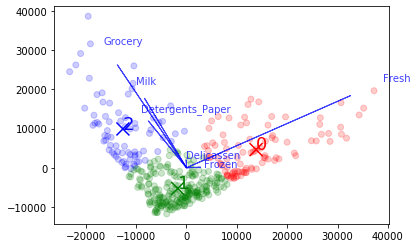

In [23]:
# Visualize all the samples. Give them the color of their cluster label
fig = plt.figure()
ax = fig.add_subplot(111)

if PLOT_TYPE_TEXT:
  # Plot the index of the sample, so you can further investigate it in your dset
  for i in range(len(T)): ax.text(T[i,0], T[i,1], wsc.index[i], color=c[labels[i]], alpha=0.75, zorder=600000)
  ax.set_xlim(min(T[:,0])*1.2, max(T[:,0])*1.2)
  ax.set_ylim(min(T[:,1])*1.2, max(T[:,1])*1.2)
else:
  # Plot a regular scatter plot
  sample_colors = [ c[labels[i]] for i in range(len(T)) ]
  ax.scatter(T[:, 0], T[:, 1], c=sample_colors, marker='o', alpha=0.2)


# Plot the Centroids as X's, and label them
ax.scatter(CC[:, 0], CC[:, 1], marker='x', s=169, linewidths=3, zorder=1000, c = c[:3])


for i in range(len(centroids)): ax.text(CC[i, 0], CC[i, 1], str(i), zorder=500010, fontsize=18, color=c[i])


# Display feature vectors for investigation:
if PLOT_VECTORS: 
    #drawVectors(T, display_pca.components_, wsc.columns, plt)

#def drawVectors(transformed_features, components_, columns, plt):
    num_columns = len(wsc.columns)

  # This function will project your *original* feature (columns)
  # onto your principal component feature-space, so that you can
  # visualize how "important" each one was in the
  # multi-dimensional scaling
  
  # Scale the principal components by the max value in
  # the transformed set belonging to that component
    xvector = display_pca.components_[0] * max(T[:,0])
    yvector = display_pca.components_[1] * max(T[:,1])

  ## Visualize projections

  # Sort each column by its length. These are your *original*
  # columns, not the principal components.
    import math
    important_features = { wsc.columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print ("Projected Features by importance:\n", important_features)

    #ax = plt.axes()

    for i in range(num_columns):
    # Use an arrow to project each original feature as a
    # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75, zorder=600000)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(wsc.columns)[i], color='b', alpha=0.75, zorder=600000)
 # return ax

plt.show()


Seems that the 3 clusters group the customers into the one loving more the Fresh products, the fans of the Frozen food and the rest :)

In [24]:
# Add the cluster label back into the dataframe and display it:
wsc['label'] = pd.Series(labels, index=wsc.index)
wsc.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,label
0,12669,9656,7561,214,2674,1338,1
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,1
3,13265,1196,4221,6404,507,1788,1
4,22615,5410,7198,3915,1777,5185,0


# De-anonymize telephone metadata
After the September 11 attacks, a series of secret regulations, laws, and processes were enacted, perhaps to better protect the citizens of the United States. These processes continued through president Bush's term and were renewed and and strengthened during the Obama administration.  
On May 24, 2006, the United States Foreign Intelligence Surveillance Court (FISC) made a fundamental shift in its approach to Section 215 of the Patriot Act, permitting the FBI to compel production of "business records" relevant to terrorism investigations, which are shared with the NSA.  
The court now defined as business records the entirety of a telephone company's call database, also known as **Call Detail Records (CDR or metadata)**.  
News of this came to public light after an ex-NSA contractor leaked the information and a few more questions were raised when it was further discovered that not just the call records of suspected terrorists were being collected in bulk... but perhaps the entirety of Americans as a whole.  
After all, if you know someone who knows someone who knows someone, your private records are relevant to a terrorism investigation.  
The white house quickly reassured the public in a press release that "Nobody is listening to your telephone calls," since, "that's not what this program is about." The public was greatly relieved.  
  
The questions explored here: exactly how useful is telephone metadata?  
It must have some use, otherwise the government wouldn't have invested however many millions they did into it secretly collecting it from phone carriers.  
Also what kind of intelligence can you extract from CDR metadata besides its face value?  
  
We use a sample CDR dataset generated for 10 people living in the Dallas, Texas metroplex area.  
It attempts to do what many researchers have already successfully done - **partly de-anonymize the CDR data**.  
People generally behave in predictable manners, moving from home to work with a few errands in between. With enough call data, given a few K-locations of interest, K-Means should be able to isolate rather easily the geolocations where a person spends the most of their time.  
CDRs are at least supposed to be protected by privacy laws, and are the basis for proprietary revenue calculations. In reality, there are quite a few public CDRs out there. Much information can be discerned from them such as social networks, criminal acts, and believe it or not, even the spread of deseases as was demonstrated by Flowminder Foundation paper on Ebola. 

## Read the data

Load up the dataset and take a peek at its head.  
Convert the date using pd.to_datetime, and the time using pd.to_timedelta

In [25]:
cdr = pd.read_csv("../Datasets/CDR.csv")
cdr.CallDate = pd.to_datetime(cdr.CallDate, errors='coerce')
cdr.CallTime = pd.to_timedelta(cdr.CallTime, errors='coerce')

cdr.dtypes

In                     int64
Out                    int64
Direction             object
CallDate      datetime64[ns]
CallTime     timedelta64[ns]
DOW                   object
Duration              object
TowerID               object
TowerLat             float64
TowerLon             float64
dtype: object

In [26]:
cdr.head(3)

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389


The metadata:  
- In and Out are the receiver's and the caller's phone numbers.
- Direction says also if the call was "missed".
- CallDate and CallTime are the exact time of the call. DOW is the Day of the Week.  
- Then we have Duration: how long the call lasted.
- and the telecommunication tower details (unique number and location).  
  
Now we want to filter only the phone calls received by one specific user (the first in the list).  
We get a distinct list of "In" phone numbers and store the values in a regular python list.  
Then we create a slice that filters to only include dataset records where the "In" feature (user phone number) is equal to the first number on our unique list above;
that is, the very first number in the dataset: User Number One.

In [27]:
usersIn = cdr.In.tolist()

user1 = cdr[cdr.In == usersIn[0]]

user1

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389
...,...,...,...,...,...,...,...,...,...,...
53140,4638472273,2666307251,Missed,2013-02-26,11:26:01.888502,Tue,0:03:08.177065,0296279d-18c3-4709-853e-3e20496ce444,32.899944,-96.910389
53141,4638472273,2145623768,Missed,2013-02-26,17:32:18.776276,Tue,0:02:30.823459,78512965-e30b-4734-ae92-47b910fe3d7f,32.899944,-96.910389
53142,4638472273,4551601645,Incoming,2013-02-26,19:12:44.730636,Tue,0:03:42.954201,8fb02570-fb3f-4381-be74-3e1accf87ec5,32.750556,-96.694722
53143,4638472273,7721472178,Incoming,2013-02-26,07:50:41.435642,Tue,0:04:04.460385,e78826ad-45b0-45d4-90ec-4776d73f1d8e,32.864167,-96.836944


As you can see, the *In* column is always the same and is the phone number of User Number One.  
There are in total 3648 calls recorded.  
  
## Plot all the call locations
We use the [Tower's Latitude and Longitude](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude) to see where the call have been received.  
The X-Coordinate should be the Longitude, and the Y-coordinate should be the tower Latitude.  
This is a mobile phone, so it can happen in different locations.

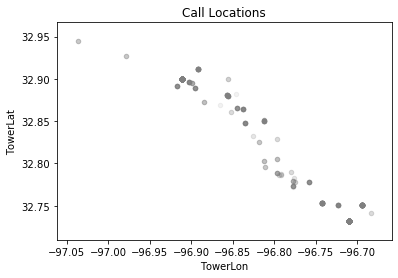

In [28]:
user1.plot.scatter(x='TowerLon', y='TowerLat', c='gray', alpha=0.1, title='Call Locations');

The locations map above is too "busy" to really wrap head around. This is where domain expertise comes into play. The intuition tells us that people are likely to behave differently on weekends:
  
On Weekends:
   1. People probably don't go into work
   2. They probably sleep in late on Saturday
   3. They probably run a bunch of random errands, since they couldn't during the week
   4. They should be home, at least during the very late hours, e.g. 1-4 AM
  
On Weekdays:
   1. People probably are at work during normal working hours
   2. They probably are at home in the early morning and during the late night
   3. They probably spend time commuting between work and home everyday

Let's examine only the records that came in on weekends (sat/sun).

In [29]:
#
# Add more filters to the user1 slice we created. Add bitwise logic for the weekend
user1 = user1[(user1.DOW == "Sat") | (user1.DOW == "Sun")]

Further filter it down for calls that came in either before 6AM OR after 10pm (22:00:00).  
We can use < and > to compare the string times, just make sure that we code them as 24h [time strings](https://en.wikipedia.org/wiki/24-hour_clock), eg: "06:00:00", "22:00:00"

In [30]:
user1 = user1[(user1.CallTime < "06:00:00") | (user1.CallTime > "22:00:00")]

In [31]:
len(user1)

28

They have been greatly reduced.  
Now we visualise the dataframe with a scatter plot as a sanity check. 
  
At this point, we still don't yet know exactly where the user is located just based off the cell phone tower position data; but considering the below are for calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where is the caller's residence:

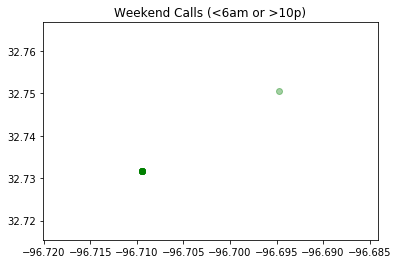

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1.TowerLon,user1.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekend Calls (<6am or >10p)');

## Clustering
We run the K-Means algorithm with a K=1. There really should only be one single area of concentration.  
If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another), then increase K=2, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location.
Or rather the location of the cell tower closest to their home.....
  
We nloy feed in Lat and Lon coordinates to the KMeans algorithm, since none of the other data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale, no feature scaling is required. finally we print out the centroid locations and add them onto the previous scatter plot using a distinguishable marker and color.

In [33]:
sliceK = user1[['TowerLon', 'TowerLat']]

model = KMeans(n_clusters=1, n_init=10, init='random')
model.fit(sliceK)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=1,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [34]:
centroids = model.cluster_centers_

centroids

array([[-96.70839404,  32.73299989]])

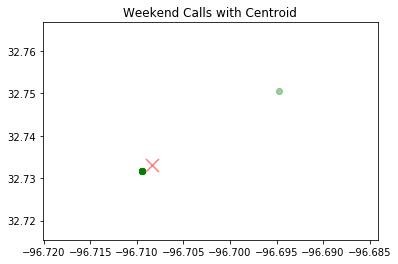

In [35]:
  #
  # Print and plot the centroids...

fig = plt.figure()
ax = fig.add_subplot(111)
  # calls location
ax.scatter(user1.TowerLon,user1.TowerLat, c='g', marker='o', alpha=0.2)
  # centroid
ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5,
             linewidths=3, s=169);

ax.set_title('Weekend Calls with Centroid');

### Repeat for other users
We can repeat the above steps for all 10 individuals to see their approximate locations and this time we look at the work location. 

We create a unique list of the phone-number values (users) stored in the "In" column of the dataset, and save it to a variable called `unique_numbers`.  
Then we manually check through unique_numbers to ensure the order the numbers appear is the same order they appear (uniquely) in the dataset: since the order matters, we cannot use sets ....

In [36]:
unique_numbers = []
for row in cdr.In:
    if row not in unique_numbers:
        unique_numbers.append(row)
        

In [37]:
def doKMeans(data, clusters=0):

  sliceK = data[['TowerLat', 'TowerLon']]

  model = KMeans(n_clusters= clusters, n_init=10, init='random')
  model.fit(sliceK)
  
  return model


In [38]:
  # Find the cluster with the most number of attached nodes
def clusterWithMostSamples(model):
      # Ensure there's at least on cluster...
    
    minSamples = 0
    maxCluster = 0
    for i in range(len(model.cluster_centers_)):
        if (model.labels_==i).sum() > minSamples:
          maxCluster = i
          minSamples = (model.labels_==i).sum()
    print ("\n  Cluster With Most Samples: Number ", maxCluster)
    print ("\n  Centroid: : ", model.cluster_centers_[maxCluster])
    return (model.labels_ == maxCluster)


In [39]:
for user in unique_numbers:
  print ("\n\nExamining person: ", user)
    
  userData = cdr[cdr.In == user]
#
# Alter the slice so that it includes only Weekday (Mon-Fri) values.
#
  userData = userData[(userData.DOW != "Sat") & (userData.DOW != "Sun")]


#
# The idea is that the call was placed before 5pm. From Midnight-07:30, the user is
# probably sleeping and won't call / wake up to take a call. There should be a brief time
# in the morning during their commute to work, then they'll spend the entire day at work.
# So the assumption is that most of the time is spent either at work, or in 2nd, at home.
#
  userData = userData[(userData.CallTime < "17:00:00")]


#
# Run K-Means with K=3 or K=4. There really should only be a two areas of concentration. If you
# notice multiple areas that are "hot" (multiple areas the usr spends a lot of time at that are FAR
# apart from one another), then increase K=5, with the goal being that all centroids except two will
# sweep up the annoying outliers and not-home, not-work travel occasions. the other two will zero in
# on the user's approximate home location and work locations. Or rather the location of the cell
# tower closest to them.....
  model = doKMeans(userData, 3)

  midWayClusterIndices = clusterWithMostSamples(model)
  



Examining person:  4638472273

  Cluster With Most Samples: Number  1

  Centroid: :  [ 32.9000009  -96.90951639]


Examining person:  1559410755

  Cluster With Most Samples: Number  1

  Centroid: :  [ 32.69557708 -96.93522725]


Examining person:  4931532174

  Cluster With Most Samples: Number  0

  Centroid: :  [ 32.77992299 -96.89338791]


Examining person:  2419930464

  Cluster With Most Samples: Number  0

  Centroid: :  [ 32.85371225 -96.8472893 ]


Examining person:  1884182865

  Cluster With Most Samples: Number  2

  Centroid: :  [ 32.92195886 -96.75768121]


Examining person:  3688089071

  Cluster With Most Samples: Number  0

  Centroid: :  [ 32.81198486 -96.87034706]


Examining person:  4555003213

  Cluster With Most Samples: Number  1

  Centroid: :  [ 32.75203793 -96.74437494]


Examining person:  2068627935

  Cluster With Most Samples: Number  0

  Centroid: :  [ 32.72097347 -96.83039184]


Examining person:  2894365987

  Cluster With Most Samples: Number  0


# Fighting crime
We now explore the City of Chicago's Crime data set, which is part of their Open Data initiative.  
This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present.

You can find the dataset on the [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2)
where you can also see several visualisations and export it (download as CSV).  
The dataset analysed here is filtered to the cases where the *Primary Type* (the Illinois Crime Code) is equal to 'GAMBLING'.  
Feel free to try other codes.    
  
## Load and process the data

In [40]:
# Load the dataset
#
cc = pd.read_csv("../Datasets/Crimes_-_2001_to_present.csv", index_col="ID")


In [41]:
#
# Drop any ROWs with nans in them
#
cc.dropna(inplace=True) 

#
# Print out the dtypes of your dset
#
cc.describe()

,IUCR,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,12830.000000,12830.000000,12830.000000,12830.000000,12830.000000,12830.0,1.283000e+04,1.283000e+04,12830.000000,12830.000000,12830.000000
mean,1660.422058,1083.257132,10.302416,21.253079,40.183866,19.0,1.162338e+06,1.881345e+06,2007.625409,41.830055,-87.679929
std,8.620933,608.198385,5.956533,11.195696,19.459785,0.0,1.598157e+04,2.696251e+04,3.610334,0.074222,0.058109
min,1610.000000,111.000000,1.000000,1.000000,1.000000,19.0,1.100658e+06,1.815111e+06,2001.000000,41.647924,-87.905227
25%,1661.000000,624.000000,6.000000,15.000000,25.000000,19.0,1.149715e+06,1.859745e+06,2005.000000,41.770517,-87.725704
50%,1661.000000,1014.000000,10.000000,22.000000,35.000000,19.0,1.163364e+06,1.888615e+06,2007.000000,41.849746,-87.676321
75%,1661.000000,1522.750000,15.000000,28.000000,61.000000,19.0,1.174961e+06,1.901925e+06,2010.000000,41.886807,-87.634259
max,1697.000000,2535.000000,25.000000,50.000000,77.000000,19.0,1.202460e+06,1.951492e+06,2017.000000,42.022527,-87.534076


In [42]:
cc.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
ID,,,,,,,,,,,,,,,,,,,,,
4647776,HM172874,02/09/2006 10:29:07 PM,075XX S COLFAX AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,421,...,7.0,43.0,19,1194833.0,1855572.0,2006,04/15/2016 08:55:02 AM,41.758607,-87.561511,"(41.758607126, -87.561510616)"
4649196,HM157167,02/01/2006 12:30:27 PM,038XX W FERDINAND ST,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,1122,...,27.0,23.0,19,1150871.0,1903067.0,2006,04/15/2016 08:55:02 AM,41.889909,-87.721389,"(41.889909247, -87.721389051)"
4649661,HM159623,02/02/2006 07:02:12 PM,050XX W SUPERIOR ST,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,1531,...,28.0,25.0,19,1142605.0,1904502.0,2006,04/15/2016 08:55:02 AM,41.894005,-87.751710,"(41.89400481, -87.751710086)"
4650448,HM158020,02/01/2006 08:13:00 PM,056XX W WASHINGTON BLVD,1661,GAMBLING,GAME/DICE,RESIDENCE PORCH/HALLWAY,True,False,1512,...,29.0,25.0,19,1138430.0,1900175.0,2006,04/15/2016 08:55:02 AM,41.882208,-87.767149,"(41.882207608, -87.767148598)"
4650940,HM156984,02/01/2006 10:10:00 AM,015XX W 72ND ST,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,734,...,17.0,67.0,19,1167231.0,1856980.0,2006,04/15/2016 08:55:02 AM,41.763106,-87.662629,"(41.763105901, -87.66262925)"


Here are the main features' descriptions:
- ID: the Unique Identifier of the case record
- Case Number: the Chicago PD unique number for each case
- Date: when the incident occured, sometimes an extimation.
- Block: the address where the incident occured
- IUCR: the Crime Code. All data items have 1661= Gambling
- Desciption: the subcategory of the IUCR code
- Domestic: if the incident was domestic-related
- Beat: where the incident precisely occured. A beat is the smallest police area.
- Ward: the City district

In [43]:
cc.dtypes

Case Number              object
Date                     object
Block                    object
IUCR                      int64
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                    float64
Community Area          float64
FBI Code                  int64
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

The Date feature is a string object so we coerce it into real date and confirm by re-printing the dtypes.  
NOTE: This is a slow process...

In [44]:
cc.Date = pd.to_datetime(cc.Date, errors='coerce')

cc.dtypes

Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                             int64
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                         int64
Ward                           float64
Community Area                 float64
FBI Code                         int64
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object

Now we filter the dataframe so that we are only looking at Longitude and Latitude, since the remaining columns aren't really applicable for this purpose.

In [45]:
sliceK = cc[['Longitude', 'Latitude']]

## K-Means
And we use K-Means to try and find seven (an arbitrary number) cluster centers in this dataset:

In [46]:
model = KMeans(n_clusters=7, n_init=10, init='random')
model.fit(sliceK)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=7,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

## Print & Plot the data

we plot data with a '.' marker, with 0.3 alpha at the Longitude and Latitude locations in the dataset. Longitude = x, Latitude = y

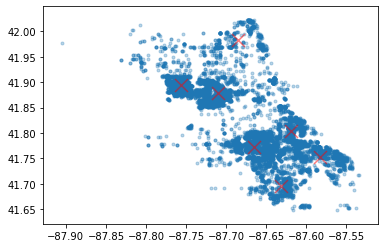

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(cc.Longitude, cc.Latitude, marker='.', alpha=0.3)

  # Print and plot the centroids...
centroids = model.cluster_centers_

ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5,
             linewidths=3, s=169);

In [48]:
centroids

array([[-87.68494997,  41.98181682],
       [-87.5825976 ,  41.75264622],
       [-87.66467376,  41.77284531],
       [-87.61949733,  41.80348972],
       [-87.75689624,  41.89345733],
       [-87.70950912,  41.87812815],
       [-87.63118325,  41.69665341]])

Filter out the data so that it only contains samples that have a Date > '2011-01-01', using indexing. Then, in a new figure, plot the crime incidents, as well as a new K-Means run's centroids.

In [49]:
cc2011 = cc[cc.Date > '2011-01-01']


In [50]:
  # Filter dataframe so that we're only looking at Longitude and Latitude
  #
sliceK = cc2011[['Longitude', 'Latitude']]


  #
  # Use K-Means to try and find seven cluster centers in this df.
  #

model = KMeans(n_clusters=7, n_init=10, init='random')
model.fit(sliceK)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=7,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

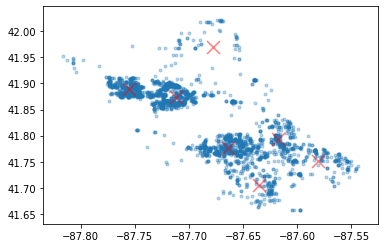

In [51]:
  # Plot data with a '.' marker, with 0.3 alpha at the Longitude,
  # and Latitude locations in your dataset. Longitude = x, Latitude = y
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(cc2011.Longitude, cc2011.Latitude, marker='.', alpha=0.3)

  #
  # Print and plot the centroids...
centroids = model.cluster_centers_

ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5,
             linewidths=3, s=169);

In [52]:
centroids

array([[-87.67743147,  41.96953954],
       [-87.66411799,  41.77626655],
       [-87.61792341,  41.79287838],
       [-87.71218464,  41.87450871],
       [-87.63498732,  41.70529706],
       [-87.580749  ,  41.75078115],
       [-87.75519682,  41.89024792]])

# Conclusions
Unsupervised learning is important for understanding the variation and grouping structure of a set of unlabeled data, and can be a useful pre-processor for supervised learning.  

It is intrinsically more difficult than supervised learning because there is no gold standard (like an outcome variable) and no single objective (like test set accuracy).  
It is an active field of research, with many recently developed tools such as self-organizing maps, independent components analysis and spectral clustering.  
A good overview is the book *Elements of Statistical Learning*, chapter 14.

## Practical issues
- Scaling of the variables matters!  
Should the observations or features first be standardized in some way? For instance, maybe the variables should be centered to have mean zero and scaled to have standard deviation one. you can try the differences when scaling or not via the second example.  
- How many clusters to choose? (K number).  
This is a difficult problem and there is no agreed-upon method. Much is left to domain-expertise and own judgement.  
Sometimes you are running K-means to get clusters to use for some later / downstream purpose. In this case, you evaluate K-means based on a metric for how well it performs for that later purpose.  
A good method is the *Elbow method*:  
you measure the cost function for an increasing number of cluster, starting from K=1.  
Plotting the results you can see that the cost function is maximum for K=1, then it decreases for each higher K but it slows down, until for a certain K the decrease is very minimal. This is the *elbow* point and could be considered a good compromise for the number of clusters: it minimises the cost function without having too many clusters.  
A similar problem is which features to use to drive the clustering?  
See Elements of Statistical Learning, chapter 13 for more details.